In [1]:
import numpy as np
import numpy.linalg as la
import os
from ctypes import c_int, c_double, POINTER, cdll
from tqdm import tqdm

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize': (8, 6)})

In [2]:
# Release dll if loaded
dll = None
# Compile cuda code and load dll
os.system("pwsh ./run.ps1 > log")
dll = cdll.LoadLibrary("./build/Release/kernel.dll")
## Define function signatures
# # void call_qpe_kernel(double* data, int nAll, int T, int R, bool unbiased)
# dll.call_qpe_kernel.argtypes = [POINTER(c_double), c_int, c_int, c_int, c_int]
# # void call_oqae_kernel(double* data, int nAll, int T)
# dll.call_oqae_kernel.argtypes = [POINTER(c_double), c_int, c_int]
# void call_mlae_kernel(double* data, int nAll, int length, int* Ms, int* Rs, int precision)
dll.call_mlae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), POINTER(c_int), c_int]
# void call_rqae_kernel(double* data, int nAll, int length, int* Ms, double eta, int precision)
dll.call_rqae_kernel.argtypes = [POINTER(c_double), c_int, c_int, POINTER(c_int), c_double, c_int]

In [3]:
nSample = 4096
a_ls = np.linspace(0, 1, 300)

Pointwise analysis of MLAE

In [ ]:
bias_MLAE = np.zeros_like(a_ls)
errs_MLAE = np.zeros(len(a_ls))
R0 = 32
K = 5

# sample cdf for length points
Ms = np.array([((1 << i) | 1) for i in range(K)], dtype=np.int32)
Rs = np.ones(K, dtype=np.int32) * R0
cost = Ms.sum()*R0
fi = (Ms**2).sum()*R0
print(f"Ms: {Ms} R:{R0} Cost: {cost} FI: {fi}")

src = np.repeat(a_ls, nSample)
res = np.copy(src)
dll.call_mlae_kernel(
    res.ctypes.data_as(POINTER(c_double)),
    len(a_ls) * nSample,
    K,
    Ms.ctypes.data_as(POINTER(c_int)),
    Rs.ctypes.data_as(POINTER(c_int)),
    10000
)

for idx, a in enumerate(a_ls):
    bias = np.mean(res[idx * nSample:(idx + 1) * nSample]) - a
    bias_MLAE[idx] = bias
    err = la.norm(res[idx * nSample:(idx + 1) * nSample] - a) / np.sqrt(nSample)
    errs_MLAE[idx] = err

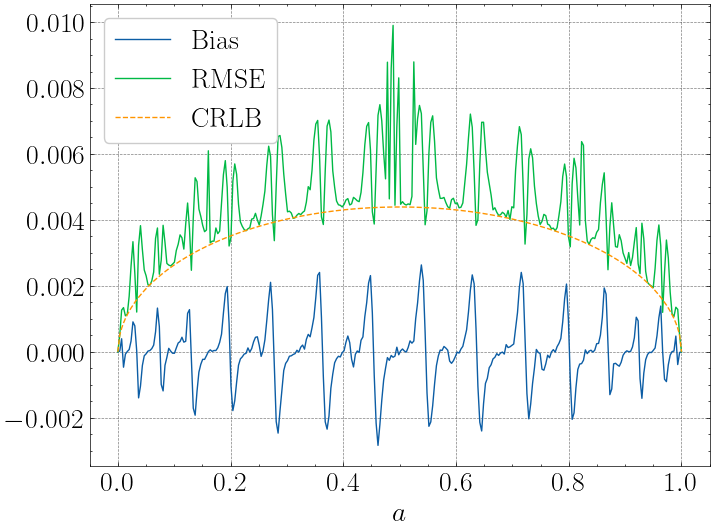

In [5]:
plt.figure()
plt.plot(a_ls, bias_MLAE, label='Bias', color='C0')
plt.plot(a_ls, errs_MLAE, label='RMSE', color='C1')
plt.plot(a_ls, np.sqrt(a_ls * (1 - a_ls) / fi), label='CRLB', color='C2', linestyle='--')
plt.xlabel('$a$')
plt.legend()
plt.savefig('bias_mlae.pdf')
plt.show()

Pointwise analysis of RQAE

In [ ]:
bias_RQAE = np.zeros_like(a_ls)
errs_RQAE = np.zeros(len(a_ls))
R0 = 32
D = 32

cdf = np.cumsum(1 / np.arange(1, D+1))
length = round(R0 * cdf[-1])
cdf /= cdf[-1]  # normalize to 1
# sample cdf for length points
Ms = np.array([np.searchsorted(cdf, np.random.random()) + 1 for i in range(length)], dtype=np.int32)
cost = Ms.sum()
fi = (Ms**2).sum()
print(f"Ms: {Ms} Cost: {cost} FI: {fi}")

src = np.repeat(a_ls, nSample)
res = np.copy(src)
dll.call_rqae_kernel(
    res.ctypes.data_as(POINTER(c_double)),
    nSample*len(a_ls),
    length,
    Ms.ctypes.data_as(POINTER(c_int)),
    1.0,
    10000
)

for idx, a in enumerate(a_ls):
    bias = np.mean(res[idx * nSample:(idx + 1) * nSample]) - a
    bias_RQAE[idx] = bias
    err = la.norm(res[idx * nSample:(idx + 1) * nSample] - a) / np.sqrt(nSample)
    errs_RQAE[idx] = err

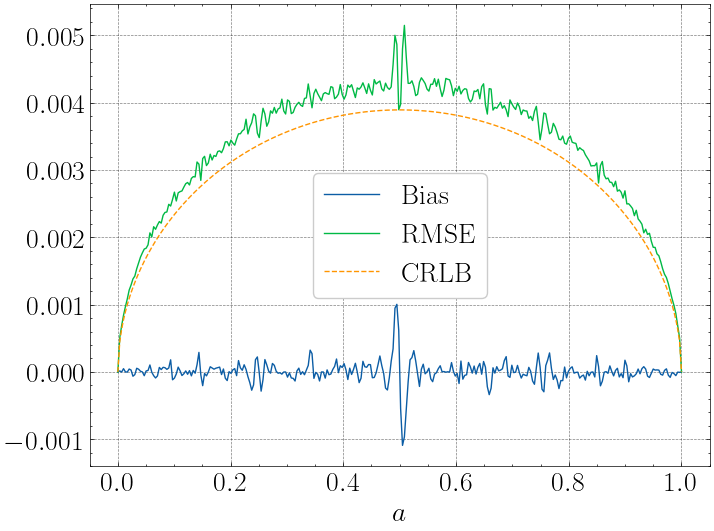

In [7]:
plt.figure()
plt.plot(a_ls, bias_RQAE, label='Bias', color='C0')
plt.plot(a_ls, errs_RQAE, label='RMSE', color='C1')
plt.plot(a_ls, np.sqrt(a_ls * (1 - a_ls) / fi), label='CRLB', color='C2', linestyle='--')
plt.xlabel('$a$')
plt.legend()
plt.savefig('bias_rqae.pdf')
plt.show()

In [8]:
Ms

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,
        8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13,
       14, 14, 14, 15, 15, 16, 16, 17, 17, 18, 19, 19, 20, 20, 21, 22, 22,
       23, 24, 25, 25, 26, 27, 28, 29, 30, 31, 32])